In [73]:
import ast
import pandas as pd

from collections import namedtuple

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, 
                             make_scorer, 
                             precision_score, 
                             recall_score, 
                             cohen_kappa_score, 
                             f1_score, 
                             matthews_corrcoef, 
                             log_loss, 
                             plot_confusion_matrix, 
                             roc_auc_score,
                             plot_roc_curve)
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import yellowbrick.model_selection as ybms

import sys
sys.path.append('../')
from utils.cv_helpers import *

In [75]:
with open('../../her2-status_config.json', 'r') as f:
    config = ast.literal_eval(f.read())

In [77]:
cv_scheme = RepeatedStratifiedKFold(n_splits=config['FOLDS'], n_repeats=config['REPEATS'], random_state=config['SEED'])

scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'Kappa': make_scorer(cohen_kappa_score),
    'MCC': make_scorer(matthews_corrcoef),
    'LL': make_scorer(log_loss),
    'F1': make_scorer(f1_score),
    'AUC': make_scorer(roc_auc_score)
}

class_weight = {1:7, 0:1}

In [79]:
config

{'CLF_NAME': 'her2-status',
 'SEED': 23,
 'HOLDOUT_SIZE': 0.3,
 'FOLDS': 3,
 'REPEATS': 10,
 'FEATURES_FILE': '../../data/processed/features/all_her2-status.csv',
 'CLASSES_FILE': '../../data/processed/targets/her2-status.csv',
 'CLASS_LABEL': 'Class',
 'TARGET_CLASSES': [1, 0],
 'ALL_CLASSES': [1, 0],
 'Y_TRAIN_FILE': '../../data/processed/ready_for_analysis/her2-status/y_train.csv',
 'Y_HOLDOUT_FILE': '../../data/processed/ready_for_analysis/her2-status/y_holdout.csv',
 'TRAIN_DATA_FILE': '../../data/processed/ready_for_analysis/her2-status/data_training.csv',
 'HOLDOUT_DATA_FILE': '../../data/processed/ready_for_analysis/her2-status/data_holdout.csv'}

In [81]:
X = pd.read_csv(config['TRAIN_DATA_FILE']).drop(['normal_sample_id', 'Tumour Average Depth', 'Normal Average Depth', 'project'], axis=1).set_index('sample_id')
y = pd.read_csv(config['Y_TRAIN_FILE']).set_index('sample_id')

## Comparison of classifiers without hyperparameters tuning

In [83]:
single_run_dt = estimator_cv_evaluation(X=X, 
                                        y=y, 
                                        estimator_name='DecisionTreeClassifier',
                                        estimator_object=DecisionTreeClassifier(),
                                        cv_scheme=cv_scheme,
                                        scoring=scoring
                                        )

single_run_rf = estimator_cv_evaluation(X=X, 
                                        y=y, 
                                        estimator_name='RandomForestClassfier',
                                        estimator_object=RandomForestClassifier(),
                                        cv_scheme=cv_scheme,
                                        scoring=scoring
                                        )

single_run_lr = estimator_cv_evaluation(X=X, 
                                        y=y, 
                                        estimator_name='LogisticRegression',
                                        estimator_object=Pipeline([('scaler', MinMaxScaler()), ('estimator', LogisticRegression(max_iter=10_000))]),
                                        cv_scheme=cv_scheme,
                                        scoring=scoring
                                        )

all_results = pd.concat([single_run_dt, single_run_rf, single_run_lr])

../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d a

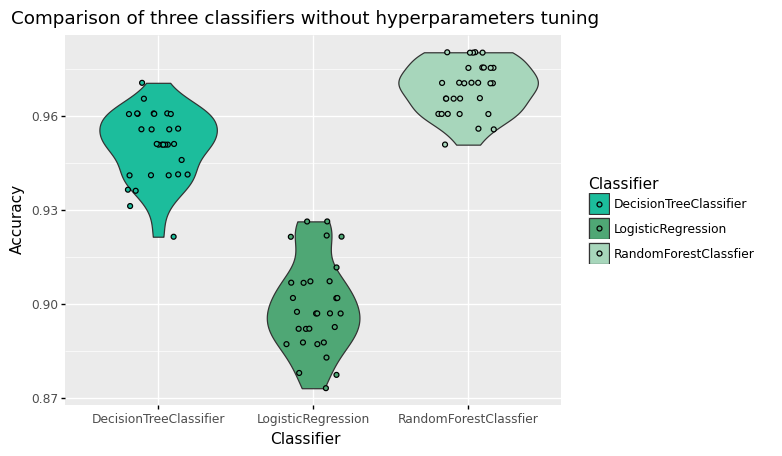

<ggplot: (8741353188443)>

In [85]:
plot_cv_estimators_comparison(all_results, 'Accuracy', rotation=0, palette=("#1cbd9c", "#4FA775", "#a7d6bb"), title='Comparison of three classifiers without hyperparameters tuning', jitter=0.2, hjust=0.5)

## Learning curves

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


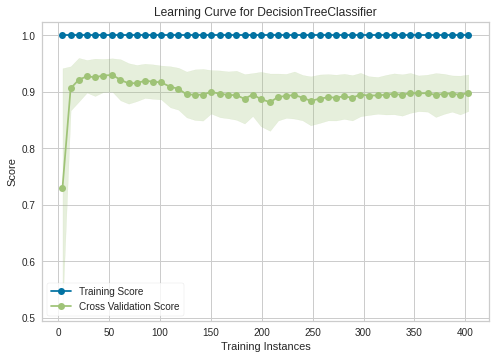

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>,
              cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=23),
              model=None, n_jobs=-1, scoring='roc_auc',
              train_sizes=array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99]))

In [87]:
ybms.learning_curve(DecisionTreeClassifier(), X, y, cv=cv_scheme, train_sizes=np.arange(0.01, 1., 0.02), n_jobs=-1, scoring='roc_auc')

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


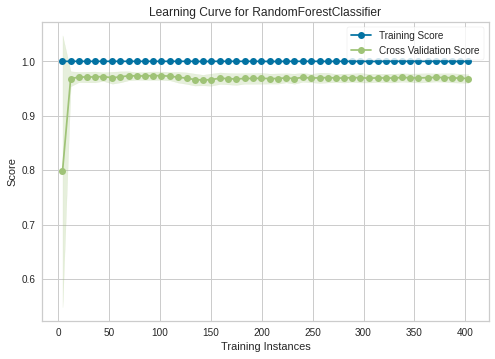

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>,
              cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=23),
              model=None, n_jobs=-1,
              train_sizes=array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99]))

In [89]:
ybms.learning_curve(RandomForestClassifier(), X, y, cv=cv_scheme, train_sizes=np.arange(0.01, 1., 0.02), n_jobs=-1)

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


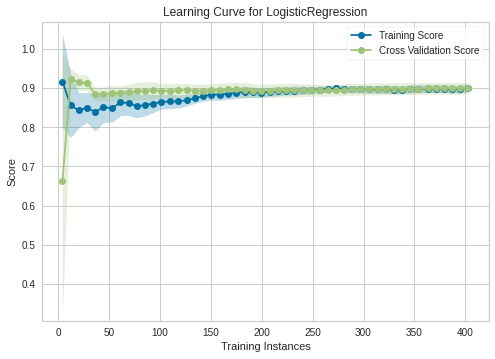

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


LearningCurve(ax=<AxesSubplot:title={'center':'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>,
              cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=3, random_state=23),
              model=None, n_jobs=-1,
              train_sizes=array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21,
       0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43,
       0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65,
       0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87,
       0.89, 0.91, 0.93, 0.95, 0.97, 0.99]))

In [91]:
ybms.learning_curve(Pipeline([('scaler', MinMaxScaler()), ('estimator', LogisticRegression(max_iter=10_000))]), X, y, cv=cv_scheme, train_sizes=np.arange(0.01, 1., 0.02), n_jobs=-1)

## Hyperparameters tuning

In [93]:
rf_search_space = [{
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [1, 2, 4],
    'classifier__min_samples_split': [2, 4, 8, 16],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_leaf': [1, 2, 4, 8, 16],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample', class_weight],
    'classifier__ccp_alpha': [0, 0.01, 0.03, 0.05, 0.1, 0.3]
}]

dt_search_space = [{
    'classifier': [DecisionTreeClassifier()],
    'classifier__min_samples_split': [2, 4, 8, 16],
    'classifier__min_samples_leaf': [1, 2, 4, 8, 16],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample', class_weight],
    'classifier__ccp_alpha': [0, 0.01, 0.03, 0.1, 0.3],
    'classifier__max_depth': [1, 2, 4]
}]

lr_search_space = [{
    'classifier': [LogisticRegression()],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__C': [0.01, 0.03, 0.1, 0.2, 0.4, 0.8],
    'classifier__class_weight': ['balanced', class_weight]
}]

In [95]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', None)
])

In [97]:
# grid_search_cv_rf = GridSearchCV(
#     estimator=pipeline,
#     param_grid=rf_search_space,
#     scoring=scoring,
#     n_jobs=-1,
#     refit='AUC',
#     cv=cv_scheme,
#     verbose=2,
#     return_train_score=True
# )

# grid_search_cv_dt = GridSearchCV(
#     estimator=pipeline,
#     param_grid=dt_search_space,
#     scoring=scoring,
#     n_jobs=-1,
#     refit='AUC',
#     cv=cv_scheme,
#     verbose=2,
#     return_train_score=True
# )

# grid_search_cv_lr = GridSearchCV(
#     estimator=pipeline,
#     param_grid=lr_search_space,
#     scoring=scoring,
#     n_jobs=-1,
#     refit='AUC',
#     cv=cv_scheme,
#     verbose=2,
#     return_train_score=True
# )

In [99]:
# grid_search_cv_rf.fit(X, y)
# grid_search_cv_dt.fit(X, y)
# grid_search_cv_lr.fit(X, y)

In [101]:
# cv_results_rf = show_cv_results(grid_search_cv_rf.cv_results_, ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1', 'Kappa'])
# cv_results_dt = show_cv_results(grid_search_cv_dt.cv_results_, ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1', 'Kappa'])
# cv_results_lr = show_cv_results(grid_search_cv_lr.cv_results_,['Accuracy', 'Precision', 'Recall', 'AUC', 'F1', 'Kappa'] )

In [103]:
# cv_results_rf

In [105]:
# cv_results_dt

In [107]:
# cv_results_lr

In [109]:
# print(grid_search_cv_rf.best_params_)
# print(grid_search_cv_dt.best_params_)
# print(grid_search_cv_lr.best_params_)


In [111]:
BestParams = namedtuple("BestParams", ["random_forest", "decision_tree", "logistic_regression"])
best_params = BestParams(
    RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced_subsample', max_depth=1, min_samples_leaf=16, min_samples_split=16, bootstrap=True, criterion='gini'),
    DecisionTreeClassifier(ccp_alpha=0.01, class_weight='balanced', max_depth=1, min_samples_leaf=1, min_samples_split=2), 
    LogisticRegression(C=0.8, class_weight={0: 1, 1: 7}, solver='liblinear')
    )

## Comparison of three classifiers with hyperparameters tuning

In [113]:
single_evaluation_rf_tuned = estimator_cv_evaluation(X, y, 'RandomForestClassifier', best_params.random_forest, cv_scheme, scoring)
single_evaluation_dt_tuned = estimator_cv_evaluation(X, y, 'DecisionTreeClassifier', best_params.decision_tree, cv_scheme, scoring)
single_evaluation_lr_tuned = estimator_cv_evaluation(X, y, 'LogisticRegression', best_params.logistic_regression, cv_scheme, scoring)

results_tuned = pd.concat([single_evaluation_rf_tuned, single_evaluation_dt_tuned, single_evaluation_lr_tuned])

../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d a

In [175]:
for metric in ['Accuracy', 'Precision', 'Recall', 'Kappa', 'F1', 'LL', 'AUC']:
    print(metric)
    print(single_evaluation_dt_tuned[metric].mean())
    print(single_evaluation_dt_tuned[metric].std())
    print('\n')

Accuracy
0.9667192730750837
0.00866902432404928


Precision
0.8616955933449965
0.053663084059376476


Recall
0.889696106362773
0.057202732366496284


Kappa
0.8540929140390809
0.037508734877505105


F1
0.8731862738000776
0.032692841394704554


LL
1.1494908464479259
0.29942217648649005


AUC
0.9338929970016114
0.026705269162762186




In [176]:
p = plot_cv_estimators_comparison(results_tuned, 'AUC', rotation=0, hjust=0.5, title='AUC comparison of three classifiers after hyperparameter tuning', plot_type='box')
p.save('../../reports/her2-status/auc_comparison_tuned.png')
p

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../reports/her2-status/auc_comparison_tuned.png


In [177]:
p = plot_cv_estimators_comparison(results_tuned, 'Accuracy', rotation=0, hjust=0.5, title='Accuracy comparison of three classifiers after hyperparameter tuning', plot_type='box')
p.save('../../reports/her2-status/accuracy_comparison_tuned.png')
p

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../reports/her2-status/accuracy_comparison_tuned.png


## Comparison of DummyClassifier with other approaches

In [119]:
dummy_classifiers = {
    'stratified': DummyClassifier(strategy='stratified', random_state=config['SEED']),
    'most_frequent': DummyClassifier(strategy='most_frequent', random_state=config['SEED']),
    'uniform': DummyClassifier(strategy='uniform', random_state=config['SEED']),
    'constant1': DummyClassifier(strategy='constant', constant=1, random_state=config['SEED']),
    'constant0': DummyClassifier(strategy='constant', constant=0, random_state=config['SEED']),
}


In [187]:
dummy_1 = estimator_cv_evaluation(X=X, 
                                  y=y, 
                                  estimator_name='DummyStratified',
                                  estimator_object=dummy_classifiers['stratified'],
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

dummy_2 = estimator_cv_evaluation(X=X, 
                                  y=y, 
                                  estimator_name='DummyMostFrequent',
                                  estimator_object=dummy_classifiers['most_frequent'],
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

dummy_3 = estimator_cv_evaluation(X=X, 
                                  y=y, 
                                  estimator_name='DummyUniform',
                                  estimator_object=dummy_classifiers['uniform'],
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

dummy_4 = estimator_cv_evaluation(X=X, 
                                  y=y, 
                                  estimator_name='DummyConstant0',
                                  estimator_object=dummy_classifiers['constant1'],
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

dummy_5 = estimator_cv_evaluation(X=X, 
                                  y=y, 
                                  estimator_name='DummyConstatnt1',
                                  estimator_object=dummy_classifiers['constant0'],
                                  cv_scheme=cv_scheme,
                                  scoring=scoring
                                  )

single_ERBB2_copy_number = estimator_cv_evaluation(X=X[['ERBB2_copy_number']], 
                                                   y=y, 
                                                   estimator_name='Single feature: ERBB2 copy number',
                                                   estimator_object=best_params.decision_tree,
                                                   cv_scheme=cv_scheme,
                                                   scoring=scoring
                                                   )

single_ERBB2_CEP17_ratio = estimator_cv_evaluation(X=X[['ERBB2_CEP17_ratio']], 
                                                   y=y, 
                                                   estimator_name='Single feature: ERBB2/CEP17 ratio',
                                                   estimator_object=best_params.decision_tree,
                                                   cv_scheme=cv_scheme,
                                                   scoring=scoring
                                                   )

single_ERBB2_minus_ploidy = estimator_cv_evaluation(X=X[['ERBB2_minus_ploidy']], 
                                                    y=y, 
                                                    estimator_name='Single feature: ERBB2 minus ploidy',
                                                    estimator_object=best_params.decision_tree,
                                                    cv_scheme=cv_scheme,
                                                    scoring=scoring
                                                    )


all_features_classifier = estimator_cv_evaluation(X=X, 
                                                  y=y, 
                                                  estimator_name='All features',
                                                  estimator_object=best_params.decision_tree,
                                                  cv_scheme=cv_scheme,
                                                  scoring=scoring
                                                  )

all_classifiers = pd.concat([dummy_1, dummy_2, dummy_3, dummy_4, dummy_5, single_ERBB2_copy_number, single_ERBB2_CEP17_ratio, single_ERBB2_minus_ploidy, all_features_classifier])

only_wanted_classifiers = pd.concat([dummy_2, single_ERBB2_copy_number, single_ERBB2_CEP17_ratio, single_ERBB2_minus_ploidy, all_features_classifier])


te-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined an

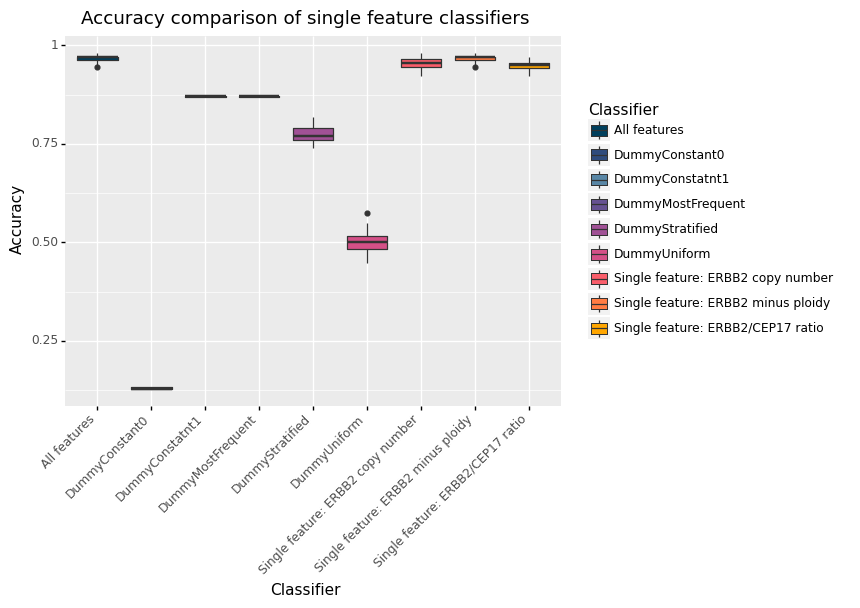

<ggplot: (8741019479896)>

In [188]:
palette = ['#003f5c', '#2f4b7c','#5886a5', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
plot_cv_estimators_comparison(all_classifiers, 'Accuracy', rotation=45, hjust=1, jitter=0, title='Accuracy comparison of single feature classifiers', palette=palette, plot_type='box')

/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/rstepien/miniconda3/envs/machine_learning/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../../reports/her2-status/accuracy_comparison.png


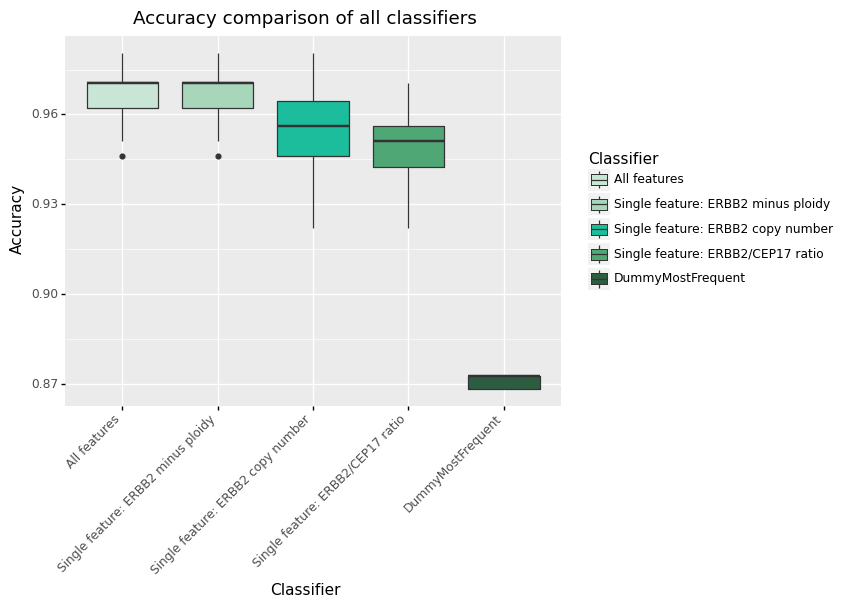

<ggplot: (8741019363729)>

In [190]:
palette = ["#C9E5D5", "#a7d6bb", "#1cbd9c", "#4FA775", "#2C5D41"]

only_wanted_classifiers['Classifier'] = pd.Categorical(only_wanted_classifiers['Classifier'], categories=['All features', 'Single feature: ERBB2 minus ploidy', 'Single feature: ERBB2 copy number', 'Single feature: ERBB2/CEP17 ratio', 'DummyMostFrequent'])

only_wanted_classifiers.Classifier.unique()
p = plot_cv_estimators_comparison(only_wanted_classifiers, 'Accuracy', rotation=45, hjust=1, jitter=0, title='Accuracy comparison of all classifiers', palette=palette, plot_type='box')
p.save('../../reports/her2-status/accuracy_comparison.png')
p

## ROC curves

In [129]:
X_holdout = pd.read_csv(config['HOLDOUT_DATA_FILE']).set_index('sample_id')
X_holdout = X_holdout.drop(['normal_sample_id', 'Tumour Average Depth', 'Normal Average Depth', 'project'], axis=1)
y_holdout = pd.read_csv(config['Y_HOLDOUT_FILE']).set_index('sample_id')

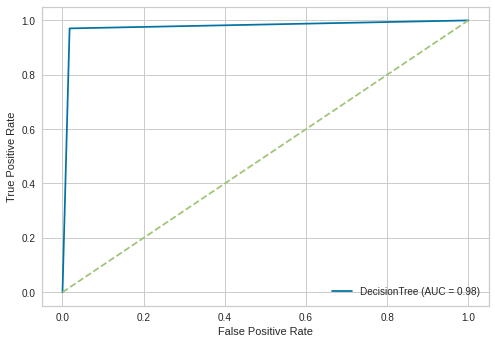

In [196]:
classifier = best_params.decision_tree
classifier.fit(X, y)
p = plot_roc_curve(classifier,
               X_holdout,
               y_holdout,
               name='DecisionTree')

p.ax_.plot([0, 1], [0, 1], '--')

In [133]:
all_X = pd.concat([X, X_holdout])
all_y = pd.concat([y, y_holdout])

In [135]:
y_pred = classifier.predict(all_X)
all_y['Predicted'] = y_pred

all_y.to_csv('../../reports/her2-status/predictions_all_samples.csv')

[Text(223.2, 224.235, 'ERBB2_minus_ploidy <= 2.265\ngini = 0.5\nsamples = 613\nvalue = [306.5, 306.5]'),
 Text(111.6, 74.745, 'gini = 0.152\nsamples = 529\nvalue = [299.612, 27.158]'),
 Text(334.79999999999995, 74.745, 'gini = 0.047\nsamples = 84\nvalue = [6.888, 279.342]')]

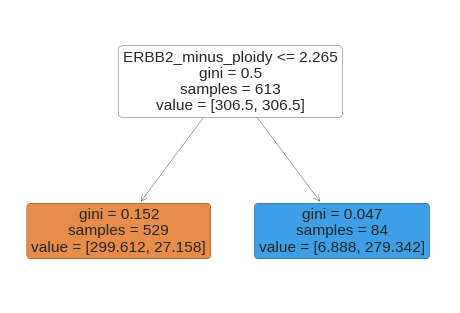

In [136]:
plot_tree(best_params.decision_tree.fit(X, y),
          feature_names=X.columns,
          filled=True,
          rounded=True,
          proportion=False
          )

# DecisionTree with params tuned vs RandomForest without tuning

In [137]:
dt_params = estimator_cv_evaluation(X=X, 
                                    y=y, 
                                    estimator_name='DecisionTree',
                                    estimator_object=best_params.decision_tree,
                                    cv_scheme=cv_scheme,
                                    scoring=scoring
                                    )

rf_no_params = estimator_cv_evaluation(X=X, 
                                       y=y, 
                                       estimator_name='RandomForest',
                                       estimator_object=RandomForestClassifier(),
                                       cv_scheme=cv_scheme,
                                       scoring=scoring
                                       )

../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
../utils/cv_helpers.py:28: DataConversionWarning: A column-vector y was passed when a 1d a

In [138]:
rf_vs_dt = pd.concat([dt_params, rf_no_params])

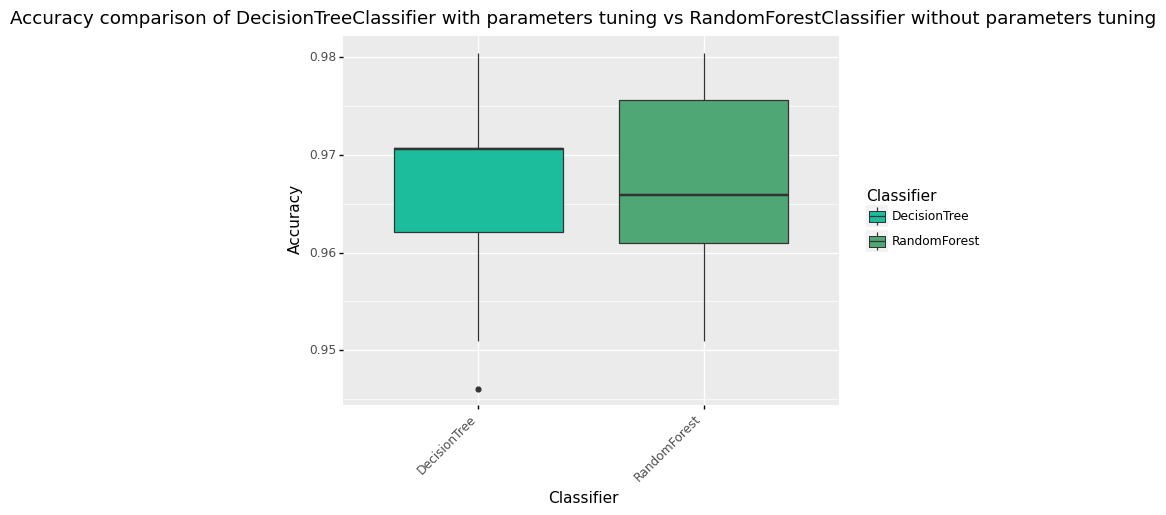

<ggplot: (8741353235059)>

In [139]:
plot_cv_estimators_comparison(rf_vs_dt, 'Accuracy', rotation=45, hjust=1, jitter=0, title='Accuracy comparison of DecisionTreeClassifier with parameters tuning vs RandomForestClassifier without parameters tuning', palette=palette, plot_type='box')

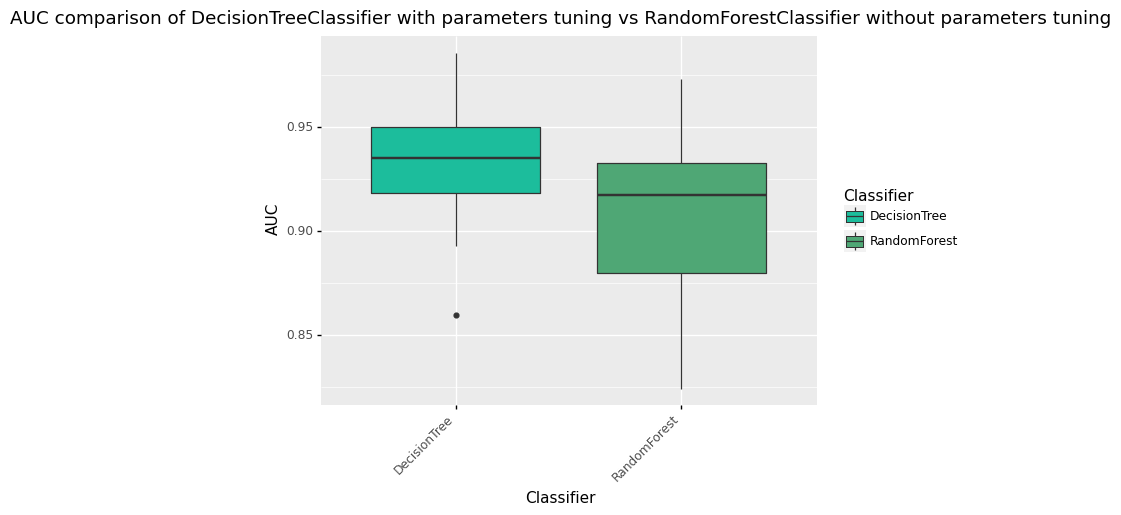

<ggplot: (8741340303903)>

In [140]:
plot_cv_estimators_comparison(rf_vs_dt, 'AUC', rotation=45, hjust=1, jitter=0, title='AUC comparison of DecisionTreeClassifier with parameters tuning vs RandomForestClassifier without parameters tuning', palette=palette, plot_type='box')